In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
data = pd.read_csv("/Users/koohyesung/Documents/cleaned_df_exploration.csv", low_memory=False)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1344041 entries, 0 to 1344040
Data columns (total 29 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   id                                   1344041 non-null  int64  
 1   loan_status                          1344041 non-null  int64  
 2   loan_amnt                            1344041 non-null  float64
 3   int_rate                             1344041 non-null  float64
 4   emp_length                           1344041 non-null  int64  
 5   dti                                  1344041 non-null  float64
 6   delinq_2yrs                          1344041 non-null  float64
 7   open_acc                             1344041 non-null  float64
 8   pub_rec                              1344041 non-null  float64
 9   revol_util                           1344041 non-null  float64
 10  mort_acc                             1344041 non-null  float64
 11

In [5]:
issue_year_counts = data['issue_year'].value_counts().sort_index()
cumulative_counts = issue_year_counts.cumsum()
print("Yearly Counts:\n", issue_year_counts)
print("\nCumulative Counts:\n", cumulative_counts)

Yearly Counts:
 issue_year
2007       212
2008      1554
2009      4702
2010     11517
2011     21712
2012     53320
2013    134726
2014    222987
2015    375389
2016    292869
2017    168967
2018     56086
Name: count, dtype: int64

Cumulative Counts:
 issue_year
2007        212
2008       1766
2009       6468
2010      17985
2011      39697
2012      93017
2013     227743
2014     450730
2015     826119
2016    1118988
2017    1287955
2018    1344041
Name: count, dtype: int64


Brier Score: 0.12090428356885817
ROC AUC Score: 0.8121837440808133


/Users/koohyesung/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


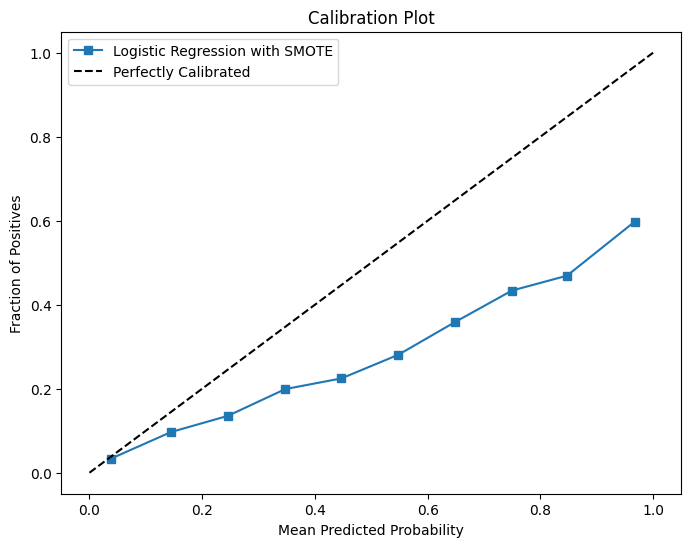

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss, roc_auc_score
from sklearn.calibration import calibration_curve
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt


# Selecting columns as specified and filtering the dataset for issue years between 2007 and 2011
columns = [
    'loan_status', 'loan_amnt', 'int_rate', 'emp_length', 'dti', 'delinq_2yrs',
    'open_acc', 'pub_rec', 'revol_util', 'mort_acc', 'fico_score_change',
    'sub_grade_num', 'home_ownership_MORTGAGE', 'home_ownership_OWN',
    'home_ownership_RENT AND OTHER', 'verification_status_Not Verified',
    'verification_status_Source Verified', 'verification_status_Verified',
    'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation',
    'purpose_major_purchase', 'purpose_medical', 'application_type_Individual',
    'application_type_Joint App', 'years_of_credit_history'
]
filtered_data = data[(data['issue_year'] >= 2007) & (data['issue_year'] <= 2011)]
filtered_data = filtered_data[columns]

# Splitting the data into features and the target variable
X = filtered_data.drop('loan_status', axis=1)
y = filtered_data['loan_status']

# Splitting the dataset into training and testing sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Setting up the resampling and the model
smote = SMOTE(random_state=42)
model = LogisticRegression(max_iter=1000, class_weight='balanced')

# Creating a pipeline that includes SMOTE and logistic regression
pipeline = Pipeline([
    ('smote', smote),
    ('logistic', model)
])

# Training the model with the original unbalanced dataset
pipeline.fit(X_train, y_train)

# Predicting probabilities
probabilities = pipeline.predict_proba(X_test)[:, 1]

# Evaluating the model
brier_score = brier_score_loss(y_test, probabilities)
roc_auc = roc_auc_score(y_test, probabilities)
print("Brier Score:", brier_score)
print("ROC AUC Score:", roc_auc)

# Calibration curve
prob_true, prob_pred = calibration_curve(y_test, probabilities, n_bins=10)
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, 's-', label='Logistic Regression with SMOTE')
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Plot')
plt.legend()
plt.show()


In [7]:
print(probabilities)

[0.09142177 0.73089073 0.06507967 ... 0.07686768 0.43394477 0.02243487]


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Brier Score: 0.10623783772185089
ROC AUC Score: 0.764036848280498


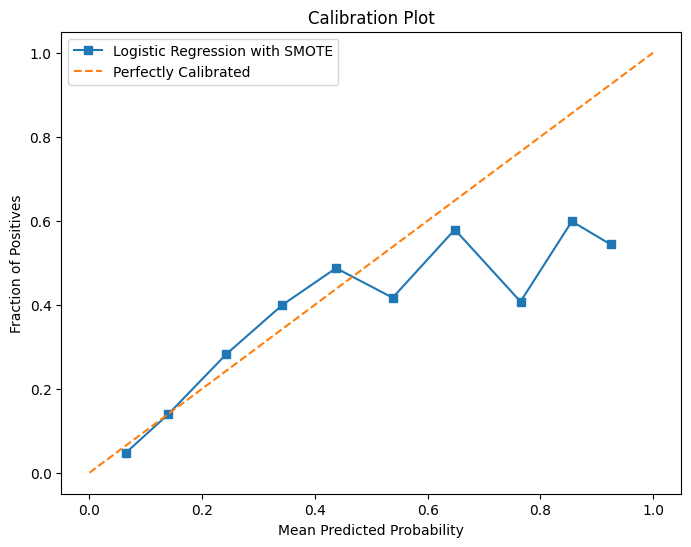

In [8]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline  # Use this to ensure SMOTE is only applied on train data
import matplotlib.pyplot as plt


# Filtering your data based on some conditions and splitting it into features and the target variable
# (Please make sure 'data' is defined in your workspace before running this snippet)
filtered_data = data[(data['issue_year'] >= 2007) & (data['issue_year'] <= 2011)]
filtered_data = filtered_data[columns]

X = filtered_data.drop('loan_status', axis=1)
y = filtered_data['loan_status']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Setting up the pipeline with a scaler, SMOTE, and logistic regression
pipeline = ImbPipeline([
    ('scaling', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('logistic', LogisticRegression(solver='saga', max_iter=10000))
])

# Define the grid of hyperparameters to search
param_grid = {
    'logistic__C': [0.01, 0.1, 1, 10, 100],
    'logistic__penalty': ['l1'],
    'logistic__class_weight': [None, 'balanced']
}

# Implement GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', verbose=1)
grid_search.fit(X_train, y_train)

# Calibrating the model with the best estimator from GridSearchCV
best_estimator = grid_search.best_estimator_['logistic']
calibrated_clf = CalibratedClassifierCV(best_estimator, method='sigmoid', cv=5)
calibrated_clf.fit(X_train, y_train)

# Predict the probabilities on the test set
y_probs = calibrated_clf.predict_proba(X_test)[:, 1]

# Calculate and print the Brier score loss and ROC AUC score
brier_score = brier_score_loss(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)
print(f'Brier Score: {brier_score}')
print(f'ROC AUC Score: {roc_auc}')

# Generate the calibration curve data
prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=10)

# Plot the calibration plot
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='s', label='Logistic Regression with SMOTE')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Plot')
plt.legend()
plt.show()



In [9]:
print(y_probs)

[0.10200185 0.34816117 0.08678418 ... 0.15228812 0.01778493 0.10019383]


In [10]:
import joblib

# Save the calibrated classifier to a file
joblib.dump(calibrated_clf, 'calibrated_classifier.pkl')

['calibrated_classifier.pkl']

In [11]:
import os
print(os.getcwd())

/Users/koohyesung/Documents


In [12]:
import joblib
import pandas as pd

# Load the calibrated classifier from a file
calibrated_clf = joblib.load('calibrated_classifier.pkl')

# Define the columns used for training to ensure consistency, plus the columns to retain
training_columns = [
    'loan_status', 'loan_amnt', 'int_rate', 'emp_length', 'dti', 'delinq_2yrs',
    'open_acc', 'pub_rec', 'revol_util', 'mort_acc', 'fico_score_change',
    'sub_grade_num', 'home_ownership_MORTGAGE', 'home_ownership_OWN',
    'home_ownership_RENT AND OTHER', 'verification_status_Not Verified',
    'verification_status_Source Verified', 'verification_status_Verified',
    'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation',
    'purpose_major_purchase', 'purpose_medical', 'application_type_Individual',
    'application_type_Joint App', 'years_of_credit_history'
]
additional_columns = ['issue_year', 'issue_month', 'id']

# Filter the data for issue years 2012 to 2018 and include additional columns
filtered_data_new = data[(data['issue_year'] >= 2012) & (data['issue_year'] <= 2018)]
filtered_data_new = filtered_data_new[training_columns + additional_columns]

# Drop 'loan_status' for prediction purposes, if it exists in columns
X_new = filtered_data_new.drop(['loan_status'] + additional_columns, axis=1)

# Use the calibrated model to predict probabilities for the new filtered dataset
y_new_probs = calibrated_clf.predict_proba(X_new)[:, 1]

# If you need binary predictions instead of probabilities
y_new_pred = calibrated_clf.predict(X_new)

# Add the predicted probabilities and classes to the filtered_data_new DataFrame
filtered_data_new['predicted_probability'] = y_new_probs
filtered_data_new['predicted_class'] = y_new_pred

# Export the DataFrame with predictions and additional columns to a CSV file
filtered_data_new.to_csv('pd_logistic.csv', index=False)

print("Data with predictions has been saved to 'pd_logistic.csv'.")


Data with predictions has been saved to 'pd_logistic.csv'.


In [13]:
from sklearn.metrics import brier_score_loss, roc_auc_score

y_new = filtered_data_new['loan_status']

# Calculate Brier Score Loss
brier_score_result = brier_score_loss(y_new, y_new_probs)
print(f"Brier Score: {brier_score_result}")

# Calculate ROC AUC Score
roc_auc_result = roc_auc_score(y_new, y_new_probs)
print(f"ROC AUC Score: {roc_auc_result}")


Brier Score: 0.12428946670734535
ROC AUC Score: 0.8542152550116867


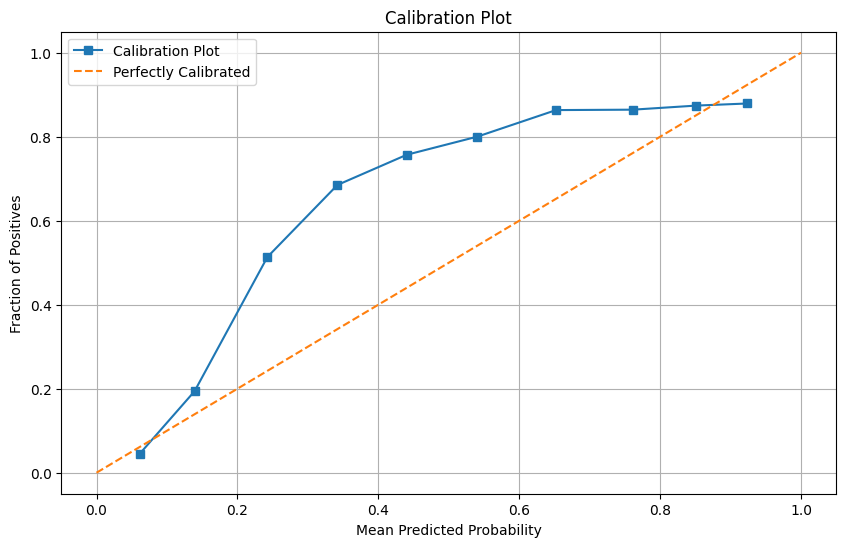

In [14]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# Generate the calibration curve data
fraction_of_positives, mean_predicted_value = calibration_curve(y_new, y_new_probs, n_bins=10)

# Create the calibration plot
plt.figure(figsize=(10, 6))
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label='Calibration Plot')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Plot')
plt.legend()
plt.grid(True)
plt.show()


In [20]:
data_pd = pd.read_csv("/Users/koohyesung/Documents/pd_logistic.csv", low_memory=False)

In [21]:
data_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1304344 entries, 0 to 1304343
Data columns (total 31 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   loan_status                          1304344 non-null  int64  
 1   loan_amnt                            1304344 non-null  float64
 2   int_rate                             1304344 non-null  float64
 3   emp_length                           1304344 non-null  int64  
 4   dti                                  1304344 non-null  float64
 5   delinq_2yrs                          1304344 non-null  float64
 6   open_acc                             1304344 non-null  float64
 7   pub_rec                              1304344 non-null  float64
 8   revol_util                           1304344 non-null  float64
 9   mort_acc                             1304344 non-null  float64
 10  fico_score_change                    1304344 non-null  float64
 11

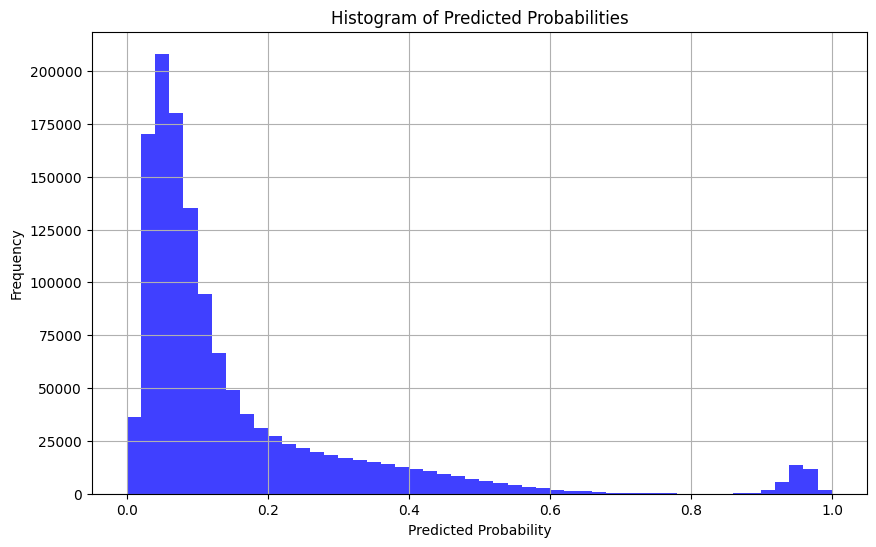

In [22]:
import matplotlib.pyplot as plt

# Plot the histogram of the 'predicted_probability' column
plt.figure(figsize=(10, 6))  # Set the figure size
plt.hist(data_pd['predicted_probability'], bins=50, alpha=0.75, color='blue')  # Histogram with 50 bins
plt.title('Histogram of Predicted Probabilities')  # Title of the histogram
plt.xlabel('Predicted Probability')  # Label for the x-axis
plt.ylabel('Frequency')  # Label for the y-axis
plt.grid(True)  # Enable grid lines to improve readability
plt.show()  # Display the plot


In [1]:
import pandas as pd

# Create a DataFrame for the model comparison
model_performance_data = {
    'Algorithm': [
        'Logistic Regression', 
        'Logistic Regression (Lasso)', 
        'Random Forest', 
        'Tuned Random Forest'
    ],
    'Hyperparameters': [
        'penalty=none, random_state=0',
        'C=0.258, solver=saga, penalty=l1, random_state=0',
        'max_depth=4, n_estimators=1483, criterion=entropy, min_samples_split=0.014, min_samples_leaf=0.000, random_state=0',
        'Parameters tuned via RandomizedSearchCV'
    ],
    'Brier Score': [
        0.121,
        0.121, # Placeholder for Logistic Regression (Lasso) Brier Score
        0.101,
        0.100
    ],
    'ROC AUC Score': [
        0.812,
        0.812, # Placeholder for Logistic Regression (Lasso) ROC AUC Score
        0.840,
        0.845
    ]
}

# Convert the data into a Pandas DataFrame
model_performance_df = pd.DataFrame(model_performance_data)

# Save the DataFrame as an Excel file
excel_file_path = '/mnt/data/model_performance_comparison.xlsx'
model_performance_df.to_excel(excel_file_path, index=False)

model_performance_df


OSError: Cannot save file into a non-existent directory: '\mnt\data'